In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyreadr import read_r
import gc

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

**1. Data loading and EDA**

1.1 Load Dataset + dataframe

In [4]:
data = read_r('data/train.rds')

In [5]:
df = data[None]

In [6]:
X = df.iloc[:, 2:]
y = df.iloc[:, 1]

1.2 General Metrics

In [7]:
var_by_Gene = X.var()
mean_by_Gene = X.mean()

In [8]:
pd.DataFrame({
    'metric': ['Mean Expression', 'Median Variance'],
    'values': [mean_by_Gene.mean(), var_by_Gene.median()]
})

,metric,values
0,Mean Expression,0.243390
1,Median Variance,0.001867


mean expression is 0.24 since most of them is 0

1.3 Top 10 most highly expressed Genes

In [9]:
top_10_genes = mean_by_Gene.sort_values(ascending=False).head(10)

In [10]:
pd.DataFrame({
    'Gene':top_10_genes.index.to_list(),
    'Mean':top_10_genes.values.tolist(),
    'Variance': var_by_Gene[top_10_genes.index.to_list()].values.tolist()
})

,Gene,Mean,Variance
0,CD74,67.735965,20681.549180
1,APOC1,62.592661,26926.408658
2,CCL2,50.338299,11655.298804
3,HLA-DRA,41.255103,5383.881679
4,S100A6,33.135823,2235.936598
5,HLA-DRB1,31.343684,4592.978040
6,MT-ND3,28.315856,1645.625256
7,MT-CO3,27.857212,2626.779998
8,HLA-A,27.205862,2328.307377
9,ISG15,25.552772,1349.995433


In [11]:
del top_10_genes

1.4 Data Distribution

+ Proportion of each label 

In [12]:
labels = y.to_numpy().astype('int8')

unique, counts = np.unique(labels, return_counts=True)

In [13]:
pd.DataFrame({
    'labels': unique,
    'ratio': counts * 100 / sum(counts)
})

,labels,ratio
0,1,1.447873
1,2,79.861984
2,3,2.676470
3,4,1.254394
4,5,0.209603
5,6,0.067718
6,7,11.931250
7,8,1.802586
8,9,0.212828
9,10,0.535294


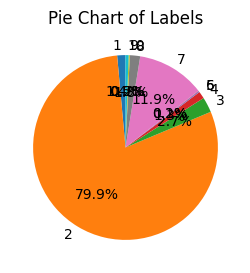

In [14]:
plt.figure(figsize=(3, 3))
plt.pie(counts, labels=[f'{val}' for val in unique], autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart of Labels')
plt.show()

-> We see Extreme Class Imbalace

Where Cell type 2 dominates all classes at ~ 80%, this can create a lot of bias in the training process

+ Which gene appears the most across cells?

Here we set expression > 0. So very little expression is also counted

In [15]:
expression_per_gene = (X > 0).sum(axis=0)

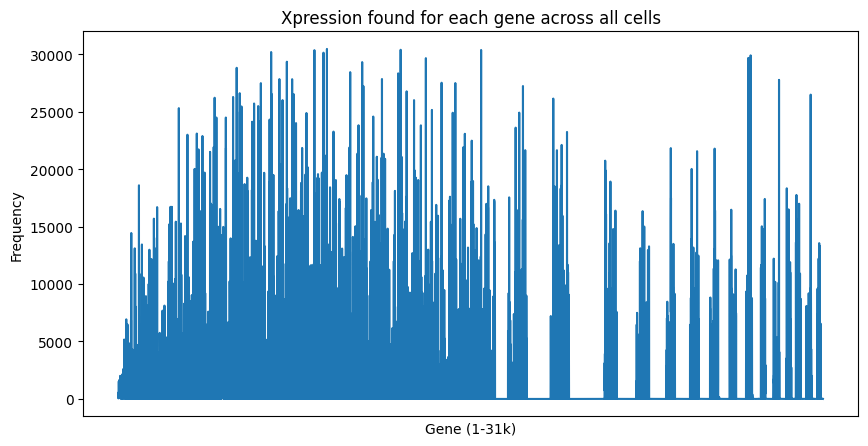

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(expression_per_gene)
plt.xticks([])
plt.title('Xpression found for each gene across all cells')
plt.xlabel('Gene (1-31k)')
plt.ylabel('Frequency')
plt.show()

In [17]:
del expression_per_gene

+ Gene distribution

-> I will pick top 20 most variable genes for visualization

In [18]:
top_20_var = var_by_Gene.sort_values(ascending=False).head(20)

In [19]:
top_20_var_names = top_20_var.index.tolist()
high_variable_df = X.loc[:, top_20_var_names]

Text(0.5, 0, 'Gene Expression')

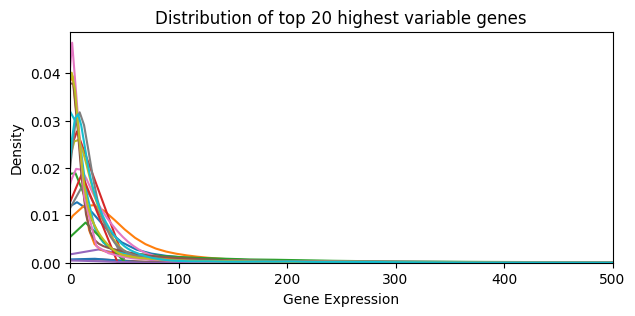

In [20]:
plt.figure(figsize=(7, 3))
for gene in top_20_var_names:
    sns.kdeplot(high_variable_df.loc[:, gene], label = gene)

plt.xlim([0, 500])

plt.title('Distribution of top 20 highest variable genes')
plt.xlabel('Gene Expression')

+ We apply log transformation to make data more stable

In [21]:
X_high_var_log = np.log(high_variable_df + 1)

In [22]:
X_high_var_log.describe()

,APOC1,CD74,CCL2,IGKV3-20,IGLV2-14,IGKV1D-13,HLA-DRA,IGKV3-11,HLA-DRB1,APOE,IGKV3-15,CCL8,IGLV2-23,IGLV3-19,IGKV2D-29,CXCL10,CCL4L2,MT-CO3,C1QB,HLA-A
count,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000,31011.000000
mean,2.144337,3.265919,1.774861,0.011633,0.012658,0.003193,2.763755,0.006076,2.384717,1.505572,0.003964,1.098546,0.005680,0.008166,0.002497,1.462522,1.007612,2.646839,1.476586,2.622142
std,2.078387,1.374290,2.153077,0.197920,0.179051,0.086141,1.474670,0.142626,1.457474,1.702138,0.129144,1.713272,0.139196,0.162800,0.097992,1.810116,1.448281,1.131188,1.680771,1.147004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.484907,0.000000,0.000000,0.000000,0.000000,1.791759,0.000000,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.945910,0.000000,1.791759
50%,1.791759,3.367296,0.000000,0.000000,0.000000,0.000000,2.944439,0.000000,2.484907,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.639057,0.693147,2.564949
75%,3.828641,4.060443,3.891820,0.000000,0.000000,0.000000,3.713572,0.000000,3.295837,2.772589,0.000000,1.945910,0.000000,0.000000,0.000000,3.044522,1.609438,3.258097,2.833213,3.367296
max,7.866339,7.490529,7.275172,9.078522,9.402777,9.385553,6.797940,8.946635,6.533789,7.322510,9.134107,6.863803,8.891649,8.786915,9.072342,6.609349,7.690286,6.642487,6.320768,6.278521


Text(0.5, 0, 'Gene Expression')

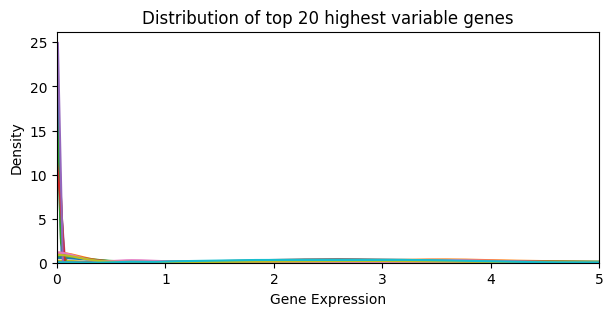

In [23]:
plt.figure(figsize=(7, 3))
for gene in top_20_var_names:
    sns.kdeplot(X_high_var_log.loc[:, gene], label = gene)

plt.xlim([0, 5])

plt.title('Distribution of top 20 highest variable genes')
plt.xlabel('Gene Expression')

In [24]:
del top_20_var
del top_20_var_names
del high_variable_df

Now log transformation on all Data


+ We also removed data with very low variance, choose threshold is 0.01

In [25]:
selector = VarianceThreshold(threshold = 0.0)
reduced_data = selector.fit_transform(X)

In [26]:
selected_columns = X.columns[selector.get_support()]
reduced_data = pd.DataFrame(reduced_data, columns=selected_columns)

In [27]:
X_log = np.log1p(reduced_data)

In [28]:
del X
gc.collect()

5906

**2. Dimensionality reduction**

2.1 Principle Component Analysis

I will choose top k genes with highest variance expression as the candidate features for PCA (based on the original data)

For each k, we will record % of variance explained by the first n components (where n will be 25% of k)

In [29]:
k = 1000

top_k_genes = var_by_Gene.sort_values(ascending=False).head(k)

+ Scree plot

I will produce a scree plot to find the elbow (that's where we should choose n_components because the goal is as small n_com as possible)

In [30]:
k = 1000

top_k_names = top_k_genes.index.tolist()
X_top_K = ( X_log - X_log.mean() ).loc[:, top_k_names].to_numpy()
pca = PCA(n_components=1000)
X_pca = pca.fit_transform(X_top_K)

In [31]:
cumulative_ratio = np.cumsum(pca.explained_variance_ratio_)

In [32]:
pd.DataFrame({
    'PC':np.arange(1, 21, 1),
    'Variance Explained': pca.explained_variance_ratio_[:20],
    'Cumulative Variance Explained': cumulative_ratio[:20]
})

,PC,Variance Explained,Cumulative Variance Explained
0,1,0.318653,0.318653
1,2,0.157040,0.475693
2,3,0.051186,0.526879
3,4,0.022023,0.548902
4,5,0.017180,0.566082
5,6,0.013982,0.580064
6,7,0.012245,0.592309
7,8,0.010677,0.602986
8,9,0.009147,0.612133
9,10,0.007618,0.619751


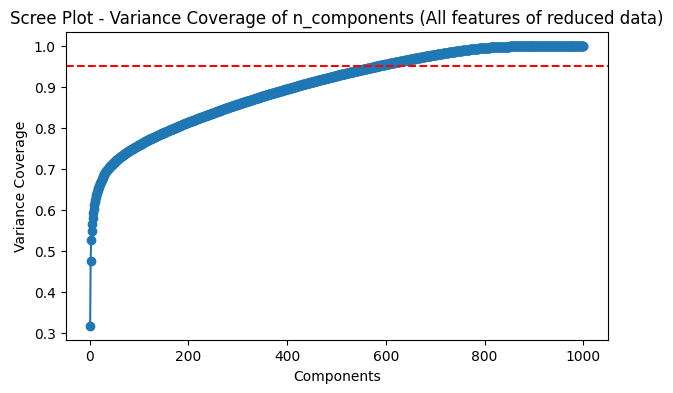

In [33]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(cumulative_ratio) + 1), cumulative_ratio, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.title('Scree Plot - Variance Coverage of n_components (All features of reduced data)')
plt.xlabel('Components')
plt.ylabel('Variance Coverage')
plt.show()

+ We would use around 600 Components if PCA fitted on 1000 most variable genes

-> I am creating another Dataframe with features are the first 600 components representing 95% variance of top 1000 variable genes

In [34]:
label_df = pd.DataFrame({
    'label':labels
})

X_pca_df = pd.DataFrame(
    X_pca[:, :600],
    columns=[f'PC{i}' for i in range(1, 601)]
)

In [35]:
#This DF represent top 600 components where it explains 95% of the variance in the original data (reduced data with log)

top_PCA_df = pd.concat([label_df, X_pca_df], axis=1)

In [36]:
del cumulative_ratio

+ In the first 2 components, how are cells clustered

In [37]:
X_2d = X_pca[:, :2]

In [38]:
df_plot = pd.DataFrame({
    'PC1': X_2d[:, 0],
    'PC2': X_2d[:, 1],
    'Label': labels  # This could be numeric or string labels
})

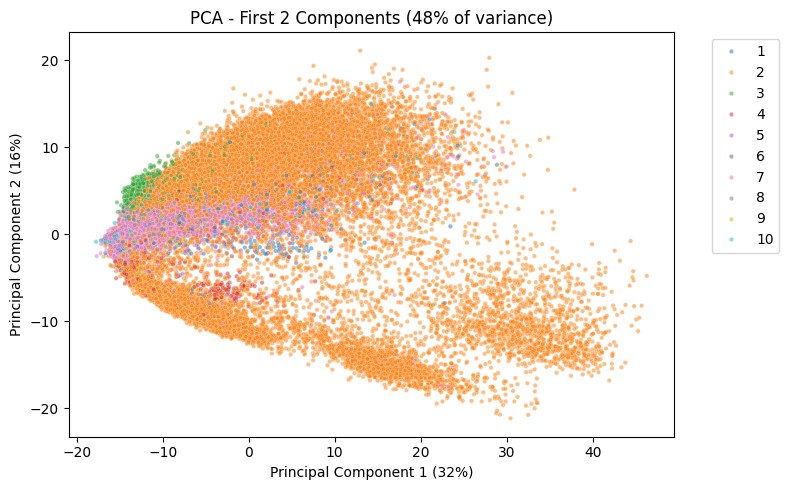

In [39]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Label', palette='tab10', s=10, alpha=0.5)
plt.title("PCA - First 2 Components (48% of variance)")
plt.xlabel("Principal Component 1 (32%)")
plt.ylabel("Principal Component 2 (16%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [40]:
del X_2d
gc.collect()

1201

**3. Method for Extreme Imbalance Data**

Since class 2 dominates all other ones, we are going to apply some resampling techniques to balance out the label distribution

<i>We are working with the **PCA top component** data from now on</i>

Here is the breakdown for the current distribution of cell types

In [41]:
pd.DataFrame({
    'values':unique,
    'count':counts,
    'ratio':counts / sum(counts)
})

,values,count,ratio
0,1,449,0.014479
1,2,24766,0.798620
2,3,830,0.026765
3,4,389,0.012544
4,5,65,0.002096
5,6,21,0.000677
6,7,3700,0.119313
7,8,559,0.018026
8,9,66,0.002128
9,10,166,0.005353


3.1 Select a specific amount of each class for validation

+ For each class, I'll leave just 10 for validation, which is equal to ~50% of the minority class.
+ Totally, 100 samples for validation (I know this is not a large number, but our goal is to minimize biases towards the minor classes)

In [42]:
#this validation set contains 10 samples for each class (10 classes)
validate_df = top_PCA_df.groupby('label').sample(n=10, random_state=42)

In [43]:
train_df = top_PCA_df.drop(validate_df.index)

In [44]:
#Let's sacrify most of the data of label 2. So it acts as undersampling later on
to_sacrifice = train_df[train_df['label'] == 2].sample(n=20000, random_state=42)
train_df.drop(to_sacrifice.index, inplace=True)

In [45]:
del to_sacrifice

3.2 Balancing data

In [46]:
unique, counts = np.unique(train_df['label'].to_numpy(), return_counts=True)

In [47]:
pd.DataFrame({
    'values':unique,
    'count':counts,
    'ratio':counts / sum(counts)
})

,values,count,ratio
0,1,439,0.040235
1,2,4756,0.435890
2,3,820,0.075154
3,4,379,0.034736
4,5,55,0.005041
5,6,11,0.001008
6,7,3690,0.338191
7,8,549,0.050316
8,9,56,0.005132
9,10,156,0.014297


We will mainly oversample classes based on its current size, but not too much else it will be overfitting


I will **oversample some classes up to 10x (Very high risk of Overfitting)**

+ Class 5 to 110 (x5)

+ Class 6 to 110 (x10)

+ Class 9 to 110 (x~5)

So we mostly risk overfitting to Class 6, which is already very low in size

In [48]:
def over_sample(X, y, strategy:dict, show_result=False):    
    '''
    This function is a customed oversampling for a given numpy array of X and y
    '''
    try:
        sm = SMOTE(sampling_strategy=strategy)
        X_res, y_res = sm.fit_resample(X, y)

        if (show_result):
            unique, counts = np.unique(y, return_counts=True)

            new_unique, new_counts = np.unique(y_res, return_counts=True)

            print(pd.DataFrame({
                'values':unique,
                'old count':counts,
                'old ratio':counts / sum(counts),
                'new count':new_counts,
                'new ratio':new_counts / sum(new_counts),
                'increased by': new_counts / sum(new_counts) - counts / sum(counts)
            }))

        return X_res, y_res
    
    except KeyError:
        print('Cannot found key, adjust strategy')

In [49]:
X_original = train_df.iloc[:, 1:].to_numpy()
y_original = train_df.iloc[:, 0].to_numpy()

In [50]:
strategy = {5: 110, 6:110, 9:110}

X_res, y_res = over_sample(X_original, y_original, strategy, show_result=True)

   values  old count  old ratio  new count  new ratio  increased by
0       1        439   0.040235        439   0.039482     -0.000753
1       2       4756   0.435890       4756   0.427736     -0.008154
2       3        820   0.075154        820   0.073748     -0.001406
3       4        379   0.034736        379   0.034086     -0.000650
4       5         55   0.005041        110   0.009893      0.004852
5       6         11   0.001008        110   0.009893      0.008885
6       7       3690   0.338191       3690   0.331864     -0.006326
7       8        549   0.050316        549   0.049375     -0.000941
8       9         56   0.005132        110   0.009893      0.004761
9      10        156   0.014297        156   0.014030     -0.000267


In [51]:
over_sampled_class = list(strategy.keys())

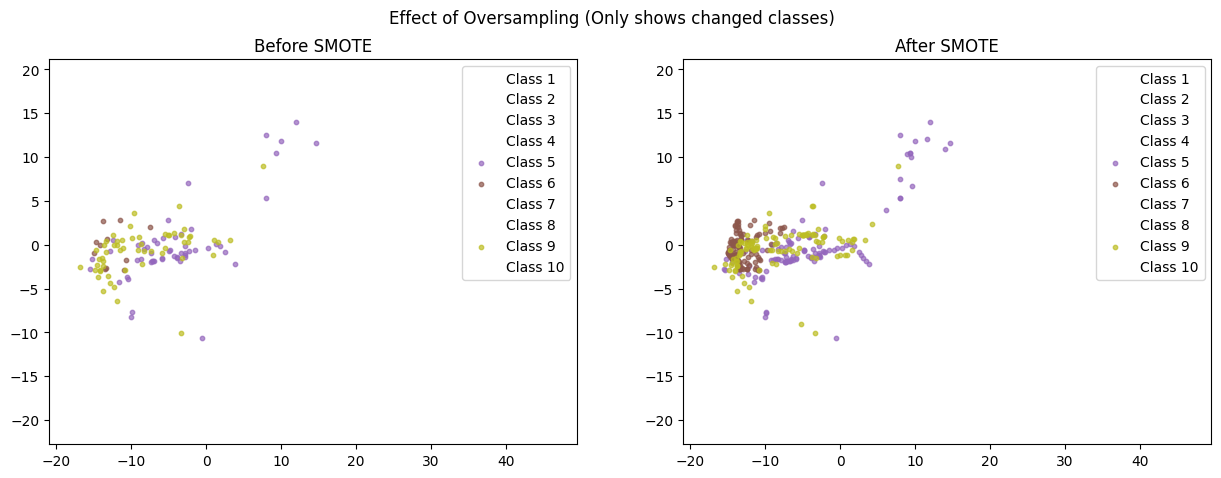

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot BEFORE SMOTE
for label in np.unique(y_original):
    alpha = 0.7 if label in over_sampled_class else 0  # make class 2 lighter
    axes[0].scatter(X_original[y_original == label, 0],
                    X_original[y_original == label, 1],
                    label=f"Class {label}", s=10, alpha=alpha)

axes[0].set_title("Before SMOTE")
axes[0].legend()

# Plot AFTER SMOTE
for label in np.unique(y_res):
    alpha = 0.7 if label in over_sampled_class else 0  # same effect
    axes[1].scatter(X_res[y_res == label, 0],
                    X_res[y_res == label, 1],
                    label=f"Class {label}", s=10, alpha=alpha)

axes[1].set_title("After SMOTE")
axes[1].legend()

fig.suptitle('Effect of Oversampling (Only shows changed classes)')

plt.show()

In [53]:
gc.collect()

4904

**4. Experimental Design**

We are running multiple Machine Learning models and benchmark them to find the best of all.


For each model:
+ We are running 30 simulations

+ -> For each simulation, we will have 5 Fold Cross Validation (We fit on 80% of data and 20% for validation) 

In [113]:
X_validate = validate_df.iloc[:, 1:].to_numpy()
y_validate = validate_df.iloc[:, 0].to_numpy()

4.1 Design a simulation matrix

+ An N_simulations x M_samples matrix of Indices (each simulation contains 5 Folds, where each is a stratified collection of samples)

In [54]:
from sklearn.model_selection import StratifiedKFold

In [55]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [56]:
#We design this CV matrix for all models
simulations = []
for sim in range(30):
    folds = []
    for train_idx, val_idx in skf.split(X_res, y_res):
        folds.append((train_idx, val_idx))
    simulations.append(folds)

del folds

4.2 Collection of models

+ Run, save metrics for benchmarking

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [80]:
n_sim = 20

4.2.1 K-nearest neighbors (KNN)

In [75]:
k_values = [10, 20, 30]

In [76]:
simulation_score = np.repeat(0.0, n_sim * 3 * len(k_values)).reshape(-1, n_sim, 3) #precision, recall and F1_score tensor

In [84]:
for k_value_id in range(len(k_values)):

    #We are running a collection of k_values
    knn = KNeighborsClassifier(n_neighbors=k_values[k_value_id])

    for sim_id in range(n_sim):
        precision = 0.0
        recall = 0.0
        f1 = 0.0

        for cv_id in range(5):

            train_indices = simulations[sim_id][cv_id][0]
            test_indices = simulations[sim_id][cv_id][1]

            #Prepare Data for fit and test
            X_train = X_res[train_indices,:]
            y_train = y_res[train_indices]

            X_test = X_res[test_indices,:]
            y_test = y_res[test_indices]

            #fitting
            knn.fit(X_train, y_train)

            #make predictions
            y_pred = knn.predict(X_test)

            #Save metrics
            precision = precision + precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
            recall = recall + recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
            f1 = f1 + f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    
    
        #Average to get metrics for 1 simulation
        precision = precision / 5
        recall = recall / 5
        f1 = f1 / 5

        #record to measurement table
        simulation_score[k_value_id, sim_id, 0] = precision #Column 0 is precision
        simulation_score[k_value_id, sim_id, 1] = recall    #Column 1 is recall
        simulation_score[k_value_id, sim_id, 2] = f1        #Column 2 is f1 score

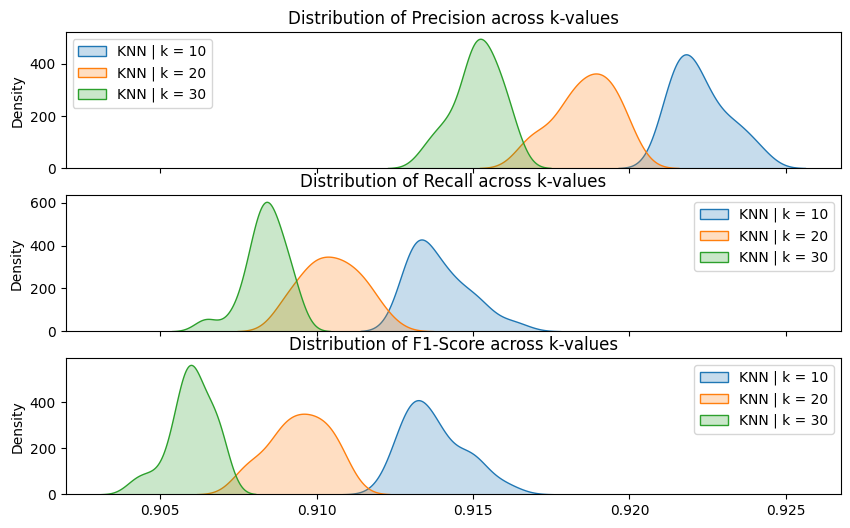

In [98]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
metrics = ['Precision', 'Recall', 'F1-Score']
#Plot Precision
for metric_id in range(3):

    for k_value_id in range(len(k_values)):

        sns.kdeplot(simulation_score[k_value_id, :, metric_id], 
                    ax = axes[metric_id],
                    label=f'KNN | k = {k_values[k_value_id]}',fill=True)

    axes[metric_id].set_title(f'Distribution of {metrics[metric_id]} across k-values')
    axes[metric_id].legend()

plt.show()

The simulation plots show that KNN(k=10) is good. We are going for k=10

+ Fit on all Dataset and test on Validation

In [317]:
knn = KNeighborsClassifier(n_neighbors=10)

In [318]:
knn.fit(X_res, y_res)

KNeighborsClassifier(n_neighbors=10)

In [319]:
y_pred = knn.predict(X_validate)

In [320]:
print('Classification report for KNN with k=10\n')
print(classification_report(y_true=y_validate, y_pred=y_pred))

Classification report for KNN with k=10

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        10
           2       0.69      0.90      0.78        10
           3       0.80      0.80      0.80        10
           4       0.88      0.70      0.78        10
           5       1.00      0.90      0.95        10
           6       0.77      1.00      0.87        10
           7       0.71      1.00      0.83        10
           8       1.00      0.60      0.75        10
           9       0.89      0.80      0.84        10
          10       1.00      0.90      0.95        10

    accuracy                           0.85       100
   macro avg       0.87      0.85      0.85       100
weighted avg       0.87      0.85      0.85       100



In [321]:
del knn
del y_pred
gc.collect()

10921

4.2.2 Random Forest

In [125]:
from sklearn.ensemble import RandomForestClassifier

In [161]:
n_estimator_value = [50, 100, 150]

In [ ]:
n_sim = 20

In [162]:
simulation_score = np.repeat(0.0, n_sim * 3 * len(n_estimator_value)).reshape(-1, n_sim, 3) #precision, recall and F1_score tensor

In [163]:
for n_estimator_id in range(len(n_estimator_value)):

    #We are running a collection of k_values
    rf = RandomForestClassifier(n_estimators=n_estimator_value[n_estimator_id],
                                max_depth=20, 
                                random_state=42)

    for sim_id in range(n_sim):
        precision = 0.0
        recall = 0.0
        f1 = 0.0

        for cv_id in range(5):

            train_indices = simulations[sim_id][cv_id][0]
            test_indices = simulations[sim_id][cv_id][1]

            #Prepare Data for fit and test
            X_train = X_res[train_indices,:]
            y_train = y_res[train_indices]

            X_test = X_res[test_indices,:]
            y_test = y_res[test_indices]

            #fitting
            rf.fit(X_train, y_train)

            #make predictions
            y_pred = rf.predict(X_test)

            #Save metrics
            precision = precision + precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
            recall = recall + recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
            f1 = f1 + f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    
    
        #Average to get metrics for 1 simulation
        precision = precision / 5
        recall = recall / 5
        f1 = f1 / 5

        #record to measurement table
        simulation_score[n_estimator_id, sim_id, 0] = precision #Column 0 is precision
        simulation_score[n_estimator_id, sim_id, 1] = recall    #Column 1 is recall
        simulation_score[n_estimator_id, sim_id, 2] = f1        #Column 2 is f1 score

    print(f'Finish RF with n={n_estimator_value[n_estimator_id]}')

Finish RF with n=50
Finish RF with n=100
Finish RF with n=150


+ Visualization of simulation

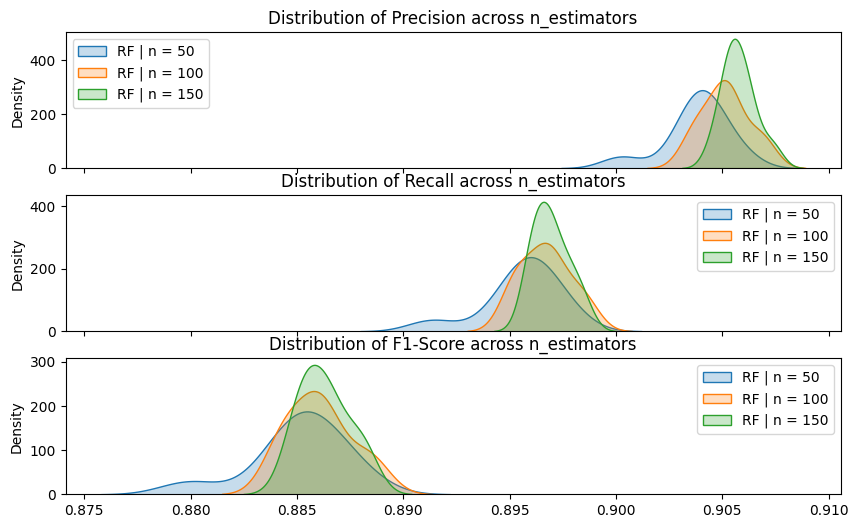

In [164]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
metrics = ['Precision', 'Recall', 'F1-Score']

for metric_id in range(3):

    for n_estimator_id in range(len(n_estimator_value)):

        sns.kdeplot(simulation_score[n_estimator_id, :, metric_id], 
                    ax = axes[metric_id],
                    label=f'RF | n = {n_estimator_value[n_estimator_id]}',fill=True)

    axes[metric_id].set_title(f'Distribution of {metrics[metric_id]} across n_estimators')
    axes[metric_id].legend()

plt.show()

+ The simulation plots show that n_est = 150 is good.

In [358]:
rf = RandomForestClassifier(n_estimators=150,
                                max_depth=20, 
                                random_state=42)

In [359]:
rf.fit(X_res, y_res)

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=42)

In [360]:
y_pred = rf.predict(X_validate)

In [361]:
print('Classification report for Random Forest with n_est= 150\n')
print(classification_report(y_true=y_validate, y_pred=y_pred))

Classification report for Random Forest with n_est= 150

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        10
           2       0.38      1.00      0.56        10
           3       1.00      0.60      0.75        10
           4       1.00      0.60      0.75        10
           5       1.00      0.80      0.89        10
           6       0.00      0.00      0.00        10
           7       0.32      1.00      0.49        10
           8       1.00      0.30      0.46        10
           9       1.00      0.40      0.57        10
          10       1.00      0.70      0.82        10

    accuracy                           0.63       100
   macro avg       0.77      0.63      0.62       100
weighted avg       0.77      0.63      0.62       100



In [362]:
del rf
del y_pred
gc.collect()

2804

4.2.3 Support Vector Machines

In [252]:
from sklearn.svm import SVC

In [282]:
n_sim = 20

C_values = [0.1, 1, 10]

In [283]:
simulation_score = np.repeat(0.0, n_sim * 3 * len(C_values)).reshape(-1, n_sim, 3) #precision, recall and F1_score tensor

In [284]:
for c_val_id in range(len(C_values)):

    svm = SVC(kernel='linear', C=C_values[c_val_id], gamma='scale') 

    for sim_id in range(n_sim):
        precision = 0.0
        recall = 0.0
        f1 = 0.0

        for cv_id in range(5):

            train_indices = simulations[sim_id][cv_id][0]
            test_indices = simulations[sim_id][cv_id][1]

            #Prepare Data for fit and test
            X_train = X_res[train_indices,:]
            y_train = y_res[train_indices]

            X_test = X_res[test_indices,:]
            y_test = y_res[test_indices]

            #fitting
            svm.fit(X_train, y_train)

            #make predictions
            y_pred = svm.predict(X_test)

            #Save metrics
            precision = precision + precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
            recall = recall + recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
            f1 = f1 + f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    
    
        #Average to get metrics for 1 simulation
        precision = precision / 5
        recall = recall / 5
        f1 = f1 / 5

        #record to measurement table
        simulation_score[c_val_id, sim_id, 0] = precision #Column 0 is precision
        simulation_score[c_val_id, sim_id, 1] = recall    #Column 1 is recall
        simulation_score[c_val_id, sim_id, 2] = f1        #Column 2 is f1 score

    print(f'Finish SVMs with c={C_values[c_val_id]}')

Finish SVMs with c=0.1
Finish SVMs with c=1
Finish SVMs with c=10


+ Visualization of simulation

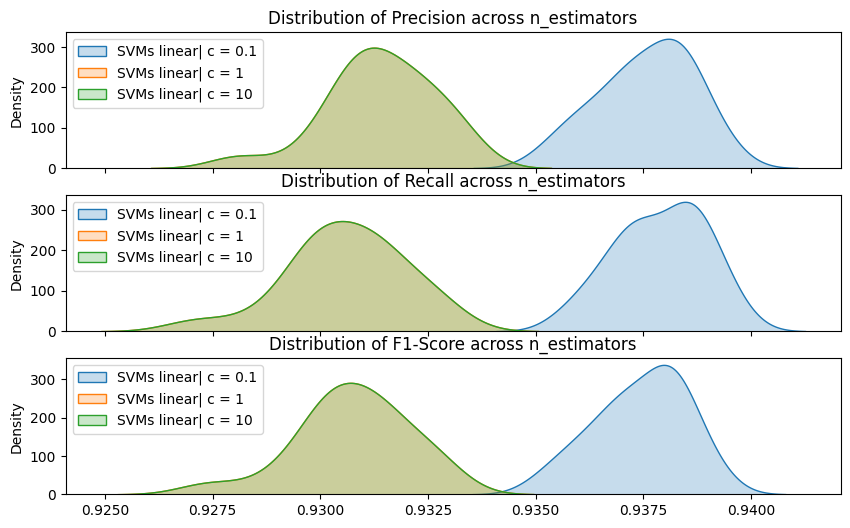

In [285]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
metrics = ['Precision', 'Recall', 'F1-Score']

for metric_id in range(3):

    for c_val_id in range(len(C_values)):

        sns.kdeplot(simulation_score[c_val_id, :, metric_id], 
                    ax = axes[metric_id],
                    label=f'SVMs linear| c = {C_values[c_val_id]}',fill=True)

    axes[metric_id].set_title(f'Distribution of {metrics[metric_id]} across n_estimators')
    axes[metric_id].legend()

plt.show()

It seems to be that high regularization (c=10) is pretty much the same as (c=1)

!!! Although CV shows c=0.1 outperforms c=1, validation says otherwise

**C=0.1**

In [337]:
svm = SVC(kernel='linear', C=0.1, gamma='scale') 

In [338]:
svm.fit(X_res, y_res)

SVC(C=0.1, kernel='linear')

In [339]:
y_pred = svm.predict(X_validate)

In [340]:
print('Classification report for SVMs (kernel = linear) with c= 0.1\n')

print(classification_report(y_true=y_validate, y_pred=y_pred))

Classification report for SVMs (kernel = linear) with c= 0.1

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       0.57      0.80      0.67        10
           3       0.69      0.90      0.78        10
           4       0.75      0.60      0.67        10
           5       1.00      1.00      1.00        10
           6       1.00      0.90      0.95        10
           7       0.77      1.00      0.87        10
           8       1.00      0.70      0.82        10
           9       1.00      0.80      0.89        10
          10       1.00      0.80      0.89        10

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



**C=1**

In [330]:
svm = SVC(kernel='linear', C=1, gamma='scale') 

In [331]:
svm.fit(X_res, y_res)

SVC(C=1, kernel='linear')

In [328]:
y_pred = svm.predict(X_validate)

In [329]:
print('Classification report for SVMs (kernel = linear) with c= 1\n')

print(classification_report(y_true=y_validate, y_pred=y_pred))

Classification report for SVMs (kernel = linear) with c= 1

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       0.82      0.90      0.86        10
           3       0.77      1.00      0.87        10
           4       0.82      0.90      0.86        10
           5       1.00      1.00      1.00        10
           6       1.00      0.90      0.95        10
           7       0.75      0.90      0.82        10
           8       0.88      0.70      0.78        10
           9       1.00      0.80      0.89        10
          10       1.00      0.80      0.89        10

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100



In [341]:
del svm
del y_pred

gc.collect()

1273

5. Overall

+ We have resampled data using SMOTE (we also sacrified a lot of cells of type 2 for balancing)

+ We have explored only 3 models but SVMs shows pretty good performance on most classes